# ML Pipeline

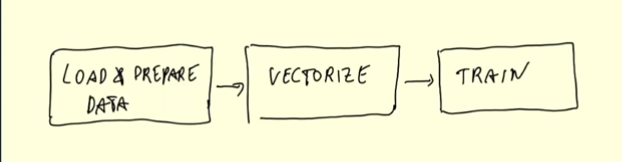

In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow

# describe without scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experimental")

<Experiment: artifact_location='/home/pastor/mlops-zoomcamp-course/01_intro/notebooks/mlruns/1', creation_time=1685302078518, experiment_id='1', last_update_time=1685302078518, lifecycle_stage='active', name='nyc-taxi-experimental', tags={}>

In [3]:
# specify the absolute path to the data file
data_path = "/home/pastor/mlops-zoomcamp-course/data/yellow/yellow_tripdata_2022-01.parquet"
data_path_02 = "/home/pastor/mlops-zoomcamp-course/data/yellow/yellow_tripdata_2022-02.parquet"

In [4]:
df = pd.read_parquet(data_path)
df_yellow = pd.read_parquet(data_path_02)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [6]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
# convert to minutes
df['duration'] = df['duration'].dt.total_seconds() / 60

In [7]:
df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

count   2463931.00
mean         14.21
std          46.45
min       -3442.40
50%          10.18
95%          31.93
98%          42.15
99%          50.85
max        8513.18
Name: duration, dtype: float64

## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [8]:
((df['duration'] >= 1) & (df['duration'] <= 60)).mean()

0.9827547930522406

In [9]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [12]:
df[categorical] = df[categorical].astype('str')

In [13]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [14]:
train_dicts = df[categorical].to_dict(orient='records')

## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [16]:
X_train
# What's the dimensionality of this matrix (number of columns)?
X_train.shape[1]

515

In [17]:
target = 'duration'
y_train = df[target].values

In [18]:
y_train

array([17.81666667,  8.4       ,  8.96666667, ..., 11.        ,
       12.05      , 27.        ])

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

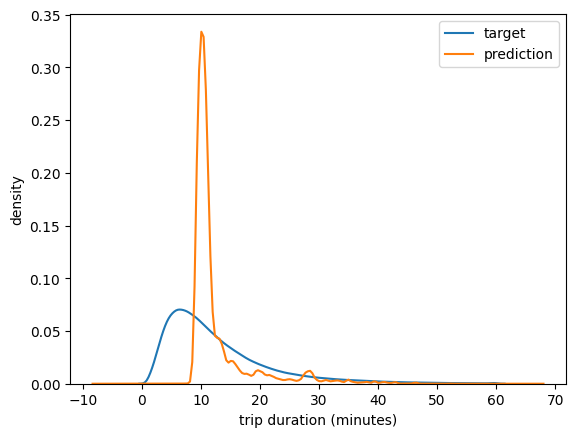

In [21]:
# density plot comparing the distribution of y_train and y_pred
sns.kdeplot(y_train, label='target')
sns.kdeplot(y_pred, label='prediction')
plt.legend()
plt.xlabel('trip duration (minutes)')
plt.ylabel('density')
plt.show()

In [22]:
mean_squared_error(y_train, y_pred, squared=False)

6.986191065500608

In [23]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    # convert to minutes
    df['duration'] = df['duration'].dt.total_seconds() / 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype('str')
    return df

In [24]:
df_train = read_dataframe(data_path)
df_val = read_dataframe(data_path_02)

In [25]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.786408015215065

In [28]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [30]:
with mlflow.start_run():
    mlflow.set_tag("model", "linear regression")

    mlflow.log_param("train-data-path", "./data/yellow/yellow_tripdata_2022-01.parquet")
    mlflow.log_param("val-data-path", "./data/yellow/yellow_tripdata_2022-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="model", artifact_path="models_pickle/")

In [31]:
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [33]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3) ~ 0.05, exp(0), ~ 1 [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1), # alias 'alpha
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
    )

[20:55:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.45129                          
[1]	validation-rmse:11.49381                          
[2]	validation-rmse:10.23525                          
[3]	validation-rmse:9.43584                           
[4]	validation-rmse:8.93148                           
[5]	validation-rmse:8.61881                           
[6]	validation-rmse:8.40254                           
[7]	validation-rmse:8.25864                           
[8]	validation-rmse:8.15443                           
[9]	validation-rmse:8.08286                           
[10]	validation-rmse:8.02410                          
[11]	validation-rmse:7.98311                          
[12]	validation-rmse:7.94751                          
[13]	validation-rmse:7.92109                          
[14]	validation-rmse:7.88643                          
[15]	validation-rmse:7.83363                          
[

KeyboardInterrupt: 

Autolog functionality works for several frameworks including fastai, tensorflow, pytorch, xgboost, lightgbm, and sklearn. You can find more details in the documentation.

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(best_result)

    booster = xgb.train(
        params=best_result,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

In [35]:
params = {
    'learning_rate': 0.5893030501119102,
    'max_depth': 16,
    'min_child_weight': 0.6385887892143437,
    'objective': 'reg:linear',
    'reg_alpha': 0.09452708475491955,
    'reg_lambda': 0.014301262054247877,
    'seed': 42,
}

mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2023/05/29 00:52:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c4d4131e2fe5425dba3989115661bccc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[00:52:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:10.36341
[1]	validation-rmse:8.55247
[2]	validation-rmse:7.94028
[3]	validation-rmse:7.71993
[4]	validation-rmse:7.60332
[5]	validation-rmse:7.36350
[6]	validation-rmse:7.26095
[7]	validation-rmse:7.20745
[8]	validation-rmse:7.17225
[9]	validation-rmse:7.13908
[10]	validation-rmse:7.07532
[11]	validation-rmse:7.05494
[12]	validation-rmse:7.02949
[13]	validation-rmse:7.01458
[14]	validation-rmse:6.88373
[15]	validation-rmse:6.86481
[16]	validation-rmse:6.83657
[17]	validation-rmse:6.76452
[18]	validation-rmse:6.75537
[19]	validation-rmse:6.66697
[20]	validation-rmse:6.65067
[21]	validation-rmse:6.63819
[22]	validation-rmse:6.54772
[23]	validation-rmse:6.53760
[24]	validation-rmse:6.52731
[25]	validation-rmse:6.43817
[26]	validation-rmse:6.42402
[27]	validation-rmse:6.39876
[28]	validation-rmse:6.38191
[29]	validation-rmse:6.37905
[30]	validation-rmse

2023/05/29 01:14:37 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/29 01:14:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pastor/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
from mloflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [ ]:
client.list_experiments()

In [ ]:
client.create_experiment(name="taxi_fare_model")

Select the best runs

In [ ]:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids="1",
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY, 
    max_results=5,
    order_by=["attribute.start_time DESC"]
    )

In [ ]:
for run in runs:
    print(f"run_id: {run.info.run_id}, params: {run.data.params}, metrics: {run.data.metrics}")

In [ ]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [ ]:
run_id = "e2b0b0b0b0b0b0b0b0b0b0b0b0b0b0b0"
model_uri = f"runs:/{run_id}/models"

mlflow.register_model(model_uri, name="taxi_fare_xgboost")

In [ ]:
model_name = "taxi_fare_xgboost"
client.list_registered_models()

latest_version = client.get_latest_versions(name=model_name)

for version in latest_version:
    print(f"version: {version.version}, stage: {version.current_stage}")

In [ ]:
model_version = 4
new_stage = "Staging"

client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archieve_existing_versions=True
    )

In [ ]:
from datetime import datetime
date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage}"

Things to do with the mlflow client:
1. Register models
2. get the latest version of the model
3. Transition the model
4. Update the model

In [ ]:
client.download_artificats(run_id=run_id, path="preprocessor", dst_path=".")

import pickle

with open("preporcessor/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

In [ ]:
X_test = preprocess(df, dv)